In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import pandas as pd
from collections import defaultdict, deque
from IPython.display import display

In [3]:
class BostonGraph():
    """
    A class that creates a graph network to be used with Dijkstras Algorithm
    """
    
    def __init__(self, nodes):
        """
        A constructor that creates an instance of a graph using one
        argument for the number of nodes
        """
        self.nodes = set(range(1, nodes))
        self.edges = {}
        self.edge_distances = {}

    def add_new_edge(self, source_node, destination_node, distance):
        """
        A function that adds a new edge to the graph network
        @input source_node: The node from which the edge starts
        @input destination_node: The node from which the edge ends
        @input distance: The weight of the node that represents distance      
        """
        self.helper_add_edge(source_node, destination_node, distance)
        self.helper_add_edge(destination_node, source_node, distance)

    def helper_add_edge(self, source_node, destination_node, distance):
        """
        A helper function that adds a new edge to the graph network
        @input source_node: The node from which the edge starts
        @input destination_node: The node from which the edge ends
        @input distance: The weight of the node that represents distance      
        """
        self.edges.setdefault(source_node, [])
        self.edges[source_node].append(destination_node)
        self.edge_distances[(source_node, destination_node)] = distance


def apply_dijkstra(Graph, source_node):
    """
    A function that applies Dijkstras algorithm to a given network
    
    @input Graph: The graph network that the algorithm should be applied to
    @input source_node: The node from which the edge starts
    """
    
    # Define the nodes that were visited, and the current node
    visited = {source_node: 0}
    current_node = source_node
    spec_path = {}

    # Set the nodes
    nodes = set(Graph.nodes)

    # Enter while condition to start
    while nodes:
        min_node = None
        # Iterate over the nodes to check if visited
        for node in nodes:
            if node in visited:
                if min_node is None:
                    min_node = node
                elif visited[node] < visited[min_node]:
                    min_node = node

        if min_node is None:
            break

        nodes.remove(min_node)
        cur_wt = visited[min_node]

        # Iterate over the edges
        for edge in Graph.edges[min_node]:
            wt = cur_wt + Graph.edge_distances[(min_node, edge)]
            # Set if condition of visited not met
            if edge not in visited or wt < visited[edge]:
                visited[edge] = wt
                spec_path[edge] = min_node

    return visited, spec_path

def create_new_route(graph, start, end):
    """
    Function that creates a route or path by applying Dijkstras
    """
    distances, paths = apply_dijkstra(graph, start)
    route = [end]
    distance = distances[end]

    # Enter while loop to add paths to route
    while end != start:
        route.append(paths[end])
        end = paths[end]

    # Inverse to correct for order
    route.reverse()
    
    return route, distance

def print_full_path(graph, start,end):
    """
    Function that graphically shows the route
    """
    # Call the create new route function
    full_route = create_new_route(graph, start,end)
    
    # Print the route
    print(full_route)
        

In [4]:
edges_path = "/content/drive/MyDrive/NEU/CS5800/data/boston_traced_map_norm.csv"
edges_df = pd.read_csv(edges_path)
edges_df["color"] = "black"
edges_df[:5]

,s,d,w,color
0,0,1,11,black
1,1,2,12,black
2,2,3,11,black
3,0,4,14,black
4,3,0,10,black


In [5]:
nodes_path = "/content/drive/MyDrive/NEU/CS5800/data/boston_nodes_norm.csv"
nodes_df = pd.read_csv(nodes_path)
nodes_df[:5]

,Node,Interesting
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
interesting_nodes = nodes_df[nodes_df["Interesting"]==1].reset_index()[["Node","Interesting"]]
interesting_nodes

,Node,Interesting
0,5,1
1,6,1
2,7,1
3,21,1
4,22,1
5,26,1
6,31,1


In [7]:
import random
# get source
source_node = random.randint(0, len(nodes_df)-1)
source_node

28

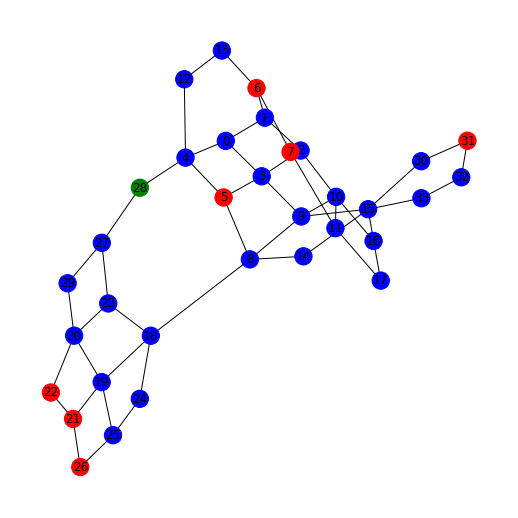

In [40]:
# Color the interesting nodes red
color_map = nodes_df["Interesting"].apply(lambda x: 'red' if x==1 else "blue")
color_map[source_node] = "green"

G = nx.Graph()

# Add nodes
for i in range(len(nodes_df)):
  node = nodes_df.iloc[i]
  G.add_node(node["Node"])

for row in edges_df.values:
  G.add_edge(row[0],row[1], weight=row[2])

plt.figure(figsize=(7, 7))
nx.draw(G, with_labels=True, node_color=color_map)
plt.show()

In [9]:
# Create new graph
g = BostonGraph(len(nodes_df))
    
# Iterate over CSV and populate graph
for row in edges_df.values:
    g.add_new_edge(row[0], row[1], row[2])

create_new_route(g, 1, 22)

([1, 2, 10, 9, 8, 18, 19, 20, 22], 75)

In [10]:
# Create new graph based on the interesting places and the source
final_nodes = interesting_nodes.append(nodes_df[nodes_df["Node"]==source_node]).reset_index()[["Node","Interesting"]].drop_duplicates()
final_nodes

,Node,Interesting
0,5,1
1,6,1
2,7,1
3,21,1
4,22,1
5,26,1
6,31,1
7,28,0


In [11]:
final_edges_df = pd.DataFrame(columns=["s","d","w"])
# create edges of interesting nodes and source
s = []
d = []
w = []

reduced_routes = {}

for i in range(len(final_nodes)):
  for j in range(i+1,len(final_nodes)):
    start = final_nodes.iloc[i]["Node"]
    end = final_nodes.iloc[j]["Node"]
    route, distance = create_new_route(g, start, end)
    key = str(start) + "-" +  str(end)
    reduced_routes[key] = route
    s.append(start)
    d.append(end)
    w.append(distance)

final_edges_df["s"] = s
final_edges_df["d"] = d
final_edges_df["w"] = w
final_edges_df["route"] = len(final_edges_df) 

# Sort edges ascending by distance
final_edges_df = final_edges_df.sort_values(by=["w"]).reset_index()[["s","d","w","route"]]
final_edges_df[:5]

,s,d,w,route
0,6,7,10,28
1,21,26,11,28
2,21,22,16,28
3,22,26,27,28
4,5,28,29,28


In [12]:
nodes_color_map = final_nodes["Node"].apply(lambda x: 'red' if x!=source_node else "green")
nodes_color_map

0      red
1      red
2      red
3      red
4      red
5      red
6      red
7    green
Name: Node, dtype: object

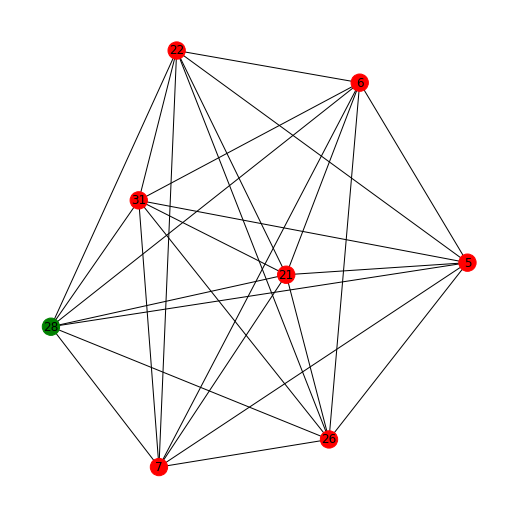

In [44]:
# reduced graph
final_G = nx.Graph()

# Add nodes
for i in range(len(final_nodes)):
  node = final_nodes.iloc[i]
  final_G.add_node(node["Node"])

# Add edges
for row in final_edges_df.values:
    final_G.add_edge(row[0],row[1], weight=row[2])

plt.figure(figsize=(7, 7))  
nx.draw(final_G, with_labels=True, node_color=nodes_color_map)

plt.show()

In [14]:
# Greedy Approach
distance = 300
tolerance = 0.1*distance
current_distance = 0
current_node = source_node
current_route_index = 0
index = final_edges_df.index
edges_len = len(final_edges_df)
visited_nodes = [source_node]

while True:
  before = current_distance
  for i in range(edges_len):
    edge = final_edges_df.iloc[i]

    if edge["s"] == current_node and edge["route"] == edges_len and edge["d"] not in visited_nodes and current_distance + edge["w"] <= distance + tolerance:
      final_edges_df.at[index[i], "route"] = current_route_index
      current_route_index += 1
      current_node = edge["d"]
      current_distance += edge["w"]
      visited_nodes.append(current_node)
      break
    elif edge["d"] == current_node and edge["route"] == edges_len and edge["s"] not in visited_nodes and current_distance + edge["w"] <= distance + tolerance:
      final_edges_df.at[index[i], "route"] = current_route_index
      current_route_index += 1
      current_node = edge["s"]
      current_distance += edge["w"]
      visited_nodes.append(current_node)
      break
    
  if before == current_distance:
    break

final_edges_df = final_edges_df.sort_values(by="route").reset_index()[["s","d","w","route"]]
final_edges_df["color"] = final_edges_df["route"].apply(lambda x: 'green' if x!=edges_len else "black")
final_edges_df[:10]

,s,d,w,route,color
0,5,28,29,0,green
1,5,7,38,1,green
2,6,7,10,2,green
3,6,31,56,3,green
4,21,31,65,4,green
5,21,26,11,5,green
6,22,26,27,6,green
7,6,21,73,28,black
8,6,26,73,28,black
9,22,31,67,28,black


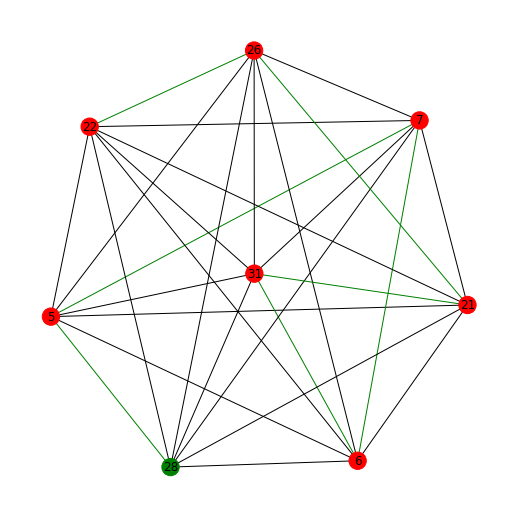

In [45]:
 # reduced graph
route_G = nx.Graph()

# Add nodes
for i in range(len(final_nodes)):
  node = final_nodes.iloc[i]
  route_G.add_node(node["Node"])

# Add edges
for row in final_edges_df.values:
  route_G.add_edge(row[0],row[1])

edges_color_map = []
for e in route_G.edges():
  for row in final_edges_df.values:
    if e[0] == row[0] and e[1] == row[1]:
      edges_color_map.append(row[4])

plt.figure(figsize=(7, 7))  
nx.draw(route_G, with_labels=True, node_color=nodes_color_map, edge_color=edges_color_map)
plt.show()

In [16]:
reconstruct_edges = []
for route in final_edges_df[final_edges_df["route"] != edges_len].values:
  key = str(route[0]) + "-" + str(route[1])
  reduced_route = reduced_routes[key]
  for i in range(len(reduced_route)-1):
    reconstruct_edges.append((reduced_route[i],reduced_route[i+1]))

reconstruct_edges = set(reconstruct_edges)
reconstruct_edges

{(2, 7),
 (3, 2),
 (4, 28),
 (5, 3),
 (5, 4),
 (6, 7),
 (7, 11),
 (8, 9),
 (9, 15),
 (10, 9),
 (11, 10),
 (15, 30),
 (18, 8),
 (19, 18),
 (21, 19),
 (21, 26),
 (22, 21),
 (30, 31)}

In [26]:
for edge in reconstruct_edges:
  for i in range(len(edges_df)):
    e = edges_df.iloc[i]
    if (e.s == edge[0] and e.d == edge[1]) or (e.s == edge[1] and e.d == edge[0]):
      edges_df.at[i, "color"] = "green"
  

edges_df[:10]

,s,d,w,color
0,0,1,11,black
1,1,2,12,black
2,2,3,11,green
3,0,4,14,black
4,3,0,10,black
5,4,5,13,green
6,5,3,12,green
7,1,6,12,black
8,6,7,10,green
9,7,2,15,green


28


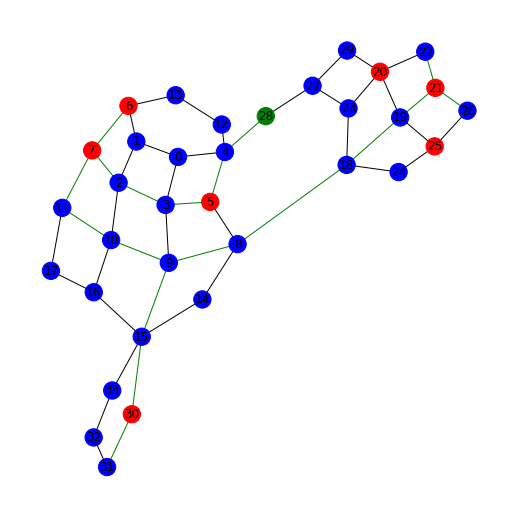

In [48]:
# Color the interesting nodes red and the source green
print(source_node)
node_color_map = nodes_df["Interesting"].apply(lambda x: 'red' if x==1 else ("blue" if x!=source_node else "green"))
node_color_map[source_node] = "green"

G = nx.Graph()
for row in edges_df.values:
    G.add_edge(row[0],row[1], weight=row[2])

edges_color_map = []
for e in G.edges():
  for row in edges_df.values:
    if (e[0] == row[0] and e[1] == row[1]) or (e[0] == row[1] and e[1] == row[0]):
      edges_color_map.append(row[3])
      break;

plt.figure(figsize=(7, 7))  
nx.draw(G, with_labels=True, node_color=node_color_map, edge_color=edges_color_map)
plt.show()

In [19]:
final_edges_df[final_edges_df["route"] != edges_len].sort_values(by="route")["w"].sum()


236